# Distracted Driver Detection

## Include Dependency

In [1]:
#import

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob
from keras.utils import np_utils

from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import model_from_json

import math


import random



from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

import h5py


Using TensorFlow backend.
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Exploratory

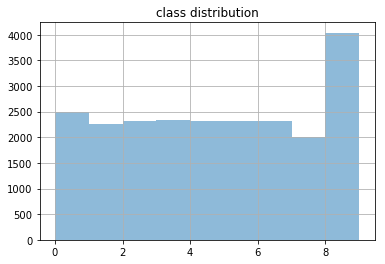

In [2]:
img_list = pd.read_csv('../capserver/data/driver_imgs_list.csv')
img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure()
img_list.hist('class_type',alpha=0.5,layout=(1,1),bins=9)
plt.title('class distribution')
plt.draw()
plt.show()

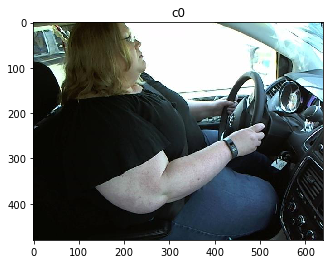

In [3]:
path = os.path.join( '..','capserver','data','imgs', 'train', 'c0', 'img_104.jpg')
import matplotlib.image as mpimg
img=mpimg.imread(path)
#resized = cv2.resize(img, (100, 80), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(img)
plt.show()

## Data Preprocessing

When we import the dataset, we need to resize the orignal image first, here is the example:

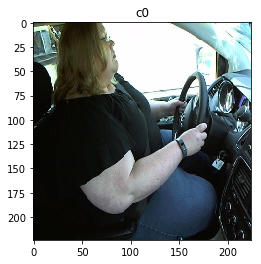

In [4]:
resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(resized)
plt.show()

We want all image to be substracted by the mean value, the example is shown below:

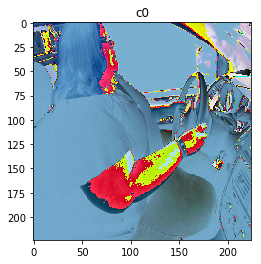

In [5]:
resized = resized.astype('float32')
mean = [103.939,116.779,123.68]
resized[:, :, 0] -= mean[0]   
resized[:, :, 1] -= mean[1]
resized[:, :, 2] -= mean[2]
plt.title('c0')
plt.imshow(resized)
plt.show()

## Create training input

Load the data and resize to create training set.

In [2]:
X_train = []
y_train = []

for i in range(10):    
    path = os.path.join( '../capserver/data/imgs/train/c' + str(i), '*.jpg')
    files = glob.glob(path)
    for fl in files:
        img = cv2.imread(fl)
        img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
        X_train.append(img)
        y_train.append(i)

In [3]:
X_train = np.array(X_train, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)

In [4]:
X_train = X_train.astype('float16')
y_train = np_utils.to_categorical(y_train, 10)

In [5]:
mean = [103.939,116.779,123.68]
X_train[:, :, :, 0] -= mean[0]   
X_train[:, :, :, 1] -= mean[1]
X_train[:, :, :, 2] -= mean[2]

print('the shape of training set: ', X_train.shape)

the shape of training set:  (22424, 224, 224, 3)


## Training Model Design

In [20]:
model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
 
model_resnet50_conv.summary()

input = Input(shape=(224,224,3),name = 'image_input')

output_resnet50_conv = model_resnet50_conv(input)

x = Flatten()(output_resnet50_conv)
x = Dense(10, activation='softmax', name='predictions')(x)

model = Model(input=input, output=x)

model.summary()
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2D (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
___________________________________________________________________________________________

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  app.launch_new_instance()


In [ ]:
#VGG16
def train_model_1():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    #model_vgg16_conv.summary()

    #Create your own input format (here 3x200x200)
    input = Input(shape=(120,100,3),name = 'image_input')

    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(input)

    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    #Create your own model 
    model = Model(input=input, output=x)

    #In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
    #model.summary()
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 

In [ ]:
#Xception
def train_model_3():
    model_xception_conv = Xception(weights='imagenet', include_top=False)
 
    input = Input(shape=(224,224,3),name = 'image_input')
 
    output_xception_conv = model_xception_conv(input)
    x = Flatten()(output_xception_conv)
    
    x = Dense(10, activation='softmax', name='predictions')(x)
    
    model = Model(input=input, output=x)
   
    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#inceptionV3
def train_model_4():
    model_InceptionV3_conv = InceptionV3(weights='imagenet', include_top=False)
 
    input = Input(shape=(224,224,3),name = 'image_input')
 
    output_InceptionV3_conv = model_InceptionV3_conv(input)
    x = Flatten()(output_InceptionV3_conv)
    
    x = Dense(10, activation='softmax', name='predictions')(x)
    
    model = Model(input=input, output=x)
   
    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#VGG19
def train_model_5():
    model_vgg19_conv = VGG19(weights='imagenet', include_top=False)
    
    input = Input(shape=(224,224,3),name = 'image_input')
  
    output_vgg19_conv = model_vgg19_conv(input)

    x = Flatten(name='flatten')(output_vgg19_conv)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    X = Dropout(0.2)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    
    model = Model(input=input, output=x)
    
    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
#Resnet50
def train_model():
    model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
 
    input = Input(shape=(224,224,3),name = 'image_input')
 
    output_resnet50_conv = model_resnet50_conv(input)
   
    x = Flatten()(output_resnet50_conv)
    #x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    
    model = Model(input=input, output=x)
   
    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Model Visualization

/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


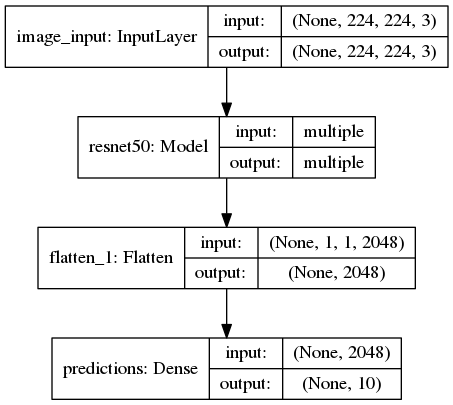

In [4]:
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG
model=train_model()
plot_model(model,show_shapes=True)
Image(filename = 'model.png')

## Train Model and Save

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  if sys.path[0] == '':


number 1 fold of 5 folds cross validation
Split into training and validation set 17939 4485
Train on 17939 samples, validate on 4485 samples
Epoch 1/40
17939/17939 [==============================] - 698s - loss: 0.2494 - acc: 0.9283 - val_loss: 0.9024 - val_acc: 0.7837
Epoch 2/40
17939/17939 [==============================] - 679s - loss: 0.0651 - acc: 0.9804 - val_loss: 0.9495 - val_acc: 0.8004
Epoch 3/40
17939/17939 [==============================] - 681s - loss: 0.0439 - acc: 0.9867 - val_loss: 0.0933 - val_acc: 0.9737
Epoch 4/40
17939/17939 [==============================] - 678s - loss: 0.0160 - acc: 0.9958 - val_loss: 0.3118 - val_acc: 0.9159
Epoch 5/40
17939/17939 [==============================] - 681s - loss: 0.0499 - acc: 0.9842 - val_loss: 0.0594 - val_acc: 0.9844
Epoch 6/40
17939/17939 [==============================] - 681s - loss: 0.0066 - acc: 0.9980 - val_loss: 0.0175 - val_acc: 0.9964
Epoch 7/40
17939/17939 [==============================] - 678s - loss: 0.0233 - acc: 

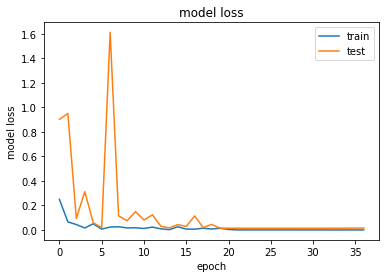

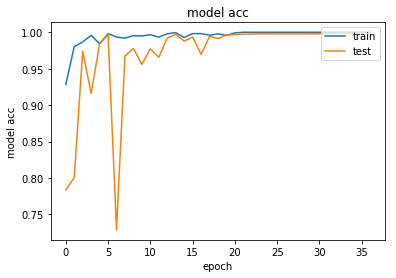

number 2 fold of 5 folds cross validation
Split into training and validation set 17939 4485
Train on 17939 samples, validate on 4485 samples
Epoch 1/40
17939/17939 [==============================] - 698s - loss: 0.2556 - acc: 0.9255 - val_loss: 0.2353 - val_acc: 0.9273
Epoch 2/40
17939/17939 [==============================] - 682s - loss: 0.0648 - acc: 0.9820 - val_loss: 0.1033 - val_acc: 0.9695
Epoch 3/40
17939/17939 [==============================] - 679s - loss: 0.0423 - acc: 0.9873 - val_loss: 4.1876 - val_acc: 0.4983
Epoch 4/40
17939/17939 [==============================] - 679s - loss: 0.0325 - acc: 0.9894 - val_loss: 0.1151 - val_acc: 0.9605
Epoch 5/40
17939/17939 [==============================] - 682s - loss: 0.0189 - acc: 0.9943 - val_loss: 0.0568 - val_acc: 0.9833
Epoch 6/40
17939/17939 [==============================] - 682s - loss: 0.0289 - acc: 0.9920 - val_loss: 0.0172 - val_acc: 0.9953
Epoch 7/40
17939/17939 [==============================] - 679s - loss: 0.0192 - acc: 

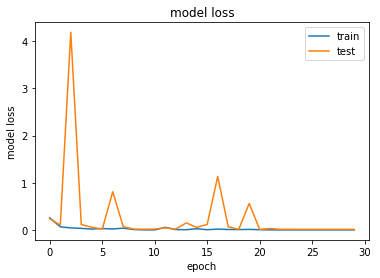

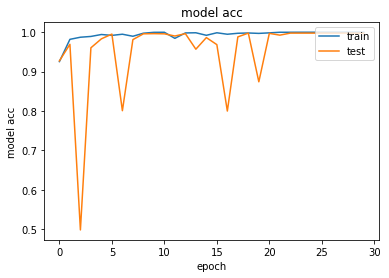

number 3 fold of 5 folds cross validation
Split into training and validation set 17939 4485
Train on 17939 samples, validate on 4485 samples
Epoch 1/40
17939/17939 [==============================] - 701s - loss: 0.2329 - acc: 0.9325 - val_loss: 0.9702 - val_acc: 0.7523
Epoch 2/40
17939/17939 [==============================] - 681s - loss: 0.0699 - acc: 0.9811 - val_loss: 0.1018 - val_acc: 0.9721
Epoch 3/40
17939/17939 [==============================] - 679s - loss: 0.0350 - acc: 0.9902 - val_loss: 0.0306 - val_acc: 0.9935
Epoch 4/40
17939/17939 [==============================] - 679s - loss: 0.0409 - acc: 0.9885 - val_loss: 0.3315 - val_acc: 0.9115
Epoch 5/40
17939/17939 [==============================] - 677s - loss: 0.0251 - acc: 0.9923 - val_loss: 0.7501 - val_acc: 0.8259
Epoch 6/40
17939/17939 [==============================] - 677s - loss: 0.0344 - acc: 0.9906 - val_loss: 0.0335 - val_acc: 0.9909
Epoch 7/40
17939/17939 [==============================] - 679s - loss: 0.0151 - acc: 

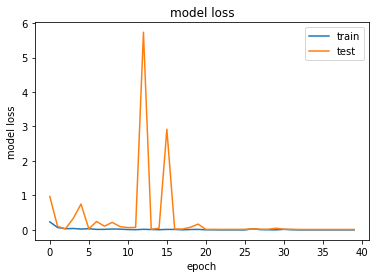

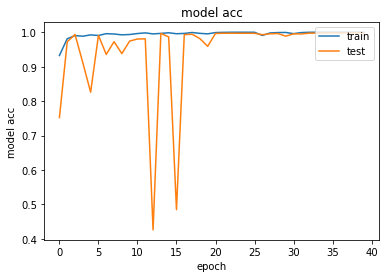

number 4 fold of 5 folds cross validation
Split into training and validation set 17939 4485
Train on 17939 samples, validate on 4485 samples
Epoch 1/40
17939/17939 [==============================] - 703s - loss: 0.2365 - acc: 0.9303 - val_loss: 0.0738 - val_acc: 0.9779
Epoch 2/40
17939/17939 [==============================] - 683s - loss: 0.0672 - acc: 0.9818 - val_loss: 1.6072 - val_acc: 0.6713
Epoch 3/40
17939/17939 [==============================] - 684s - loss: 0.0385 - acc: 0.9890 - val_loss: 0.2326 - val_acc: 0.9295
Epoch 4/40
17939/17939 [==============================] - 687s - loss: 0.0329 - acc: 0.9905 - val_loss: 0.0594 - val_acc: 0.9822
Epoch 5/40
17939/17939 [==============================] - 685s - loss: 0.0210 - acc: 0.9946 - val_loss: 9.2803 - val_acc: 0.2569
Epoch 6/40
17939/17939 [==============================] - 681s - loss: 0.0394 - acc: 0.9885 - val_loss: 0.2757 - val_acc: 0.9200
Epoch 7/40
17939/17939 [==============================] - 677s - loss: 0.0190 - acc: 

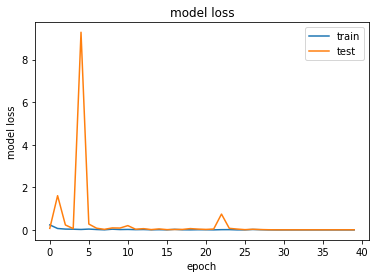

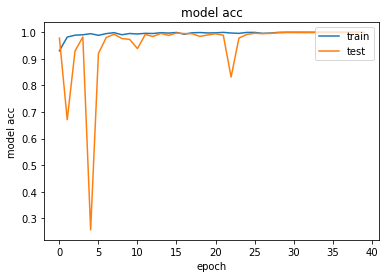

number 5 fold of 5 folds cross validation
Split into training and validation set 17940 4484
Train on 17940 samples, validate on 4484 samples
Epoch 1/40
17940/17940 [==============================] - 705s - loss: 0.2319 - acc: 0.9312 - val_loss: 0.9174 - val_acc: 0.7901
Epoch 2/40
17940/17940 [==============================] - 681s - loss: 0.0713 - acc: 0.9790 - val_loss: 1.0170 - val_acc: 0.7812
Epoch 3/40
17940/17940 [==============================] - 681s - loss: 0.0302 - acc: 0.9916 - val_loss: 3.0451 - val_acc: 0.5792
Epoch 4/40
17940/17940 [==============================] - 684s - loss: 0.0302 - acc: 0.9915 - val_loss: 0.5765 - val_acc: 0.8544
Epoch 5/40
17940/17940 [==============================] - 684s - loss: 0.0387 - acc: 0.9884 - val_loss: 0.0823 - val_acc: 0.9768
Epoch 6/40
17940/17940 [==============================] - 684s - loss: 0.0171 - acc: 0.9948 - val_loss: 0.0385 - val_acc: 0.9906
Epoch 7/40
17940/17940 [==============================] - 681s - loss: 0.0365 - acc: 

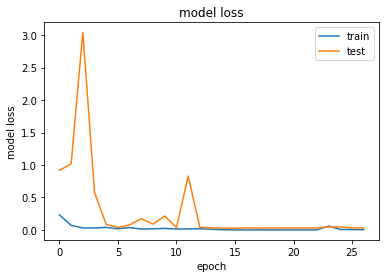

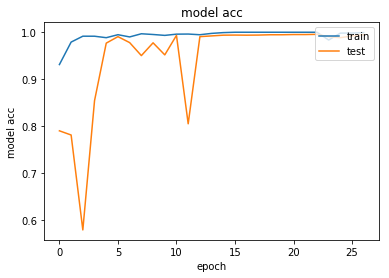

In [7]:
foldn=0
n_folds=5
log_list=[]
np.random.seed(2016)
kf = KFold(X_train.shape[0], n_folds=n_folds, shuffle=True,random_state=51)

for train, test in kf:
    model = train_model()        
    foldn += 1
    
    print('number {} fold of {} folds cross validation'.format(foldn, n_folds))
    print('Split into training and validation set', len(X_train[train]), len(X_train[test]))   
        
    weights_path = os.path.join('cache', 'weights_' + str(foldn) + '.h5')
    
    callbacks = [                
                EarlyStopping(monitor='val_loss', patience=10, verbose=0),
                ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),                
                ]
    log=model.fit(X_train[train], y_train[train], batch_size=32, epochs=40,
                  shuffle=True, verbose=1, validation_data=(X_train[test],y_train[test]),
                  callbacks=callbacks)
          
    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train','test','val_train','val_test'], loc='upper right')
    plt.show()
    
    plt.plot(log.history['acc'])
    plt.plot(log.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('model acc')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper right')
    plt.show()

In [ ]:
# 6folds for 3 models: Xception, InceptionV3, Resnet50 
"""
foldn=0
n_folds=6
log_list=[]
np.random.seed(2017)
kf = KFold(X_train.shape[0], n_folds=n_folds, shuffle=True,random_state=51)

for train, test in kf:
            
    foldn += 1
    if foldn == 1:
        model = train_model_3()
    elif foldn == 2:
        model = train_model_4()
    elif foldn == 3:
        model = train_model_3()
    elif foldn == 4:
        model = train_model_4()
    elif foldn == 5:
        model = train_model_2()
    else:
        model = train_model_2()
        
    print('number {} fold of {} folds cross validation'.format(foldn, n_folds))
    print('Split into training and validation set', len(X_train[train]), len(X_train[test]))   
        
    weights_path = os.path.join('cache', 'weights_' + str(foldn) + '.h5')
    
    callbacks = [                
                EarlyStopping(monitor='val_loss', patience=12, verbose=0),
                ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),                
                ]
    log=model.fit(X_train[train], y_train[train], batch_size=32, epochs=40,
                  shuffle=True, verbose=1, validation_data=(X_train[test],y_train[test]),
                  callbacks=callbacks)
          
    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train','test','val_train','val_test'], loc='upper right')
    plt.show()
    
    plt.plot(log.history['acc'])
    plt.plot(log.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('model acc')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper right')
    plt.show()
    
"""

## Save Model

In [8]:
with open('model.json', 'w') as f:
    f.write(model.to_json())

## Create Submission

In [8]:
batch_size = 32
fold_n = 0
y_test_all = []
nfolds=5

In [9]:
for i in range(nfolds):    
    fold_n += 1
    print('calculate the number {} fold result:'.format(fold_n))
    model = train_model()
    weights_path = os.path.join('cache', 'weights_' + str(fold_n) + '.h5')
    model.load_weights(weights_path)
    
    test_prediction = []
    for part in range(5):
        print('Reading part {} of test data'.format(part))
        
        path = os.path.join('..','capserver','data', 'imgs', 'test', '*.jpg')
        files = sorted(glob.glob(path))
        
        #split_list     
        length = len(files)    
        split_list = [files[i*length // 5: (i+1)*length // 5] for i in range(5)]

        X_test = []  
        for fl in split_list[part]:            
            img=cv2.imread(fl)
            img=cv2.resize(img,(224,224), cv2.INTER_LINEAR)
            X_test.append(img)
           
            
        X_test = np.array(X_test,dtype=np.uint8)
        X_test = X_test.astype('float16')
        
        mean=[103.939, 116.779, 123.68]
        X_test[:,:,:,0]-=mean[0]
        X_test[:,:,:,1]-=mean[1]
        X_test[:,:,:,2]-=mean[2]
        
        print('number of test data part {} : {}'.format(part, X_test.shape[0]))
        print('start predict:')
        test_prediction_part = model.predict(X_test, batch_size=batch_size, verbose=1)
        test_prediction_part = test_prediction_part.clip(min=0.005,max=1)
        for p in test_prediction_part:
             test_prediction.append(p)
    
    y_test_all.append(test_prediction)

calculate the number 1 fold result:


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  if sys.path[0] == '':


Reading part 0 of test data
number of test data part 0 : 15945
start predict:
15945/15945 [==============================] - 200s   
Reading part 1 of test data
number of test data part 1 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 2 of test data
number of test data part 2 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 3 of test data
number of test data part 3 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 4 of test data
number of test data part 4 : 15946
start predict:
15946/15946 [==============================] - 195s   
calculate the number 2 fold result:
Reading part 0 of test data
number of test data part 0 : 15945
start predict:
15945/15945 [==============================] - 200s   
Reading part 1 of test data
number of test data part 1 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 2 of test data
numbe

In [10]:
#merge
Y_test_mer=np.array(y_test_all[0])
for i in range(1, 5):
    Y_test_mer+=np.array(y_test_all[i])
Y_test_mer/=5
Y_test_mer=Y_test_mer.tolist()


In [11]:
len(Y_test_mer)

79726

In [12]:
len(y_test_all[0])

79726

In [13]:
X_id=[]
path = os.path.join('..','capserver','data', 'imgs', 'test', '*.jpg')
files = sorted(glob.glob(path))
for f in files:
    image_name = os.path.basename(f)
    X_id.append(image_name)

In [14]:
len(X_id)

79726

In [15]:
#submit

result = pd.DataFrame(Y_test_mer, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
result.loc[:,'img'] = pd.Series(X_id, index=result.index)
creat_file = os.path.join('subm', 'submission'+'.csv')
result.to_csv(creat_file, index=False)

#single model submit
for i in range(5):
    result = pd.DataFrame(y_test_all[i], columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:,'img'] = pd.Series(X_id, index=result.index)
    creat_file = os.path.join('subm', 'submission_'+str(i)+'.csv')
    print(creat_file)
    result.to_csv(creat_file, index=False)

subm/submission_0.csv
subm/submission_1.csv
subm/submission_2.csv
subm/submission_3.csv
subm/submission_4.csv


# Sample Prediction

In [40]:
def predict(path):

    X_test = []
    X_test_id = []


    #fl = os.path.basename(path)
    img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)

    X_test.append(resized)
    
    
    test_data = np.array(X_test, dtype=np.uint8)
    test_data = test_data.astype('float16')   
    mean_pixel = [103.939, 116.779, 123.68]
    print('Substract mean')
    test_data[:, :, :, 0] -= mean_pixel[0]   
    test_data[:, :, :, 1] -= mean_pixel[1]
    test_data[:, :, :, 2] -= mean_pixel[2]
    model=train_model()
    weights_path = os.path.join('cache', 'weights_' + str(5) + '.h5')
    model.load_weights(weights_path)

    test_prediction = model.predict(test_data,verbose=1)
    result=str(np.argmax(test_prediction))
    return img,result


In [41]:
path1 = os.path.join('..','capserver','data', 'imgs', 'test', 'img_1.jpg')
img,result=predict(path1)

Substract mean


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


1/1 [==============================] - 3s


In [42]:
result

'5'

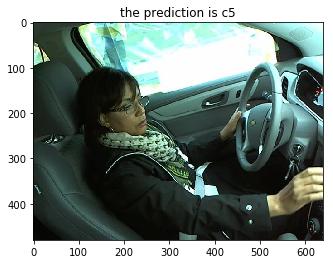

In [43]:
plt.title('the prediction is c'+result)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


1/1 [==============================] - 3s


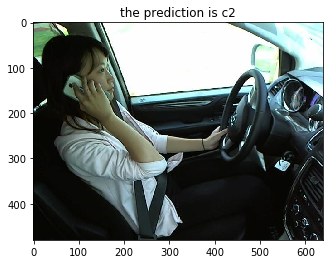

In [44]:
path2 = os.path.join('..','capserver','data', 'imgs', 'test', 'img_2.jpg')
img,result=predict(path2)
plt.title('the prediction is c'+result)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()